In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from deap import base, creator, tools, algorithms
import random

# Assuming these are defined in your original code
from wavefn import WaveFunction

# Hyperparameters
batch_size = 8
block_size = 16
max_iter = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vocab_size = 12  # Assuming this is correct based on your original tokens

tokens = ['0','1','2','3','4','5','6','7','8','9','s','e']
stoi = { ch:i for i, ch in enumerate(tokens)}
itos = { i:ch for i, ch in enumerate(tokens)}
enc = lambda s: [stoi[str(c)] for c in s]
dec = lambda l: ''.join([itos[i] for i in l[1:-1]])  # Skipping the first and last items ('s' and 'e')

# Wave generation functions (from your original code)
def generate_random_wave_profile(size):
    return ((np.random.rand(size)*10).astype(int))

def simulate_wave_sequence(batch_size, size):
    initial_profiles = [generate_random_wave_profile(size) for _ in range(batch_size)]
    final_profiles = []
    for profile in initial_profiles:
        transformed_profile = wave_fn.simulate_wave_equation(profile)
        # Remove clipping to allow for more variation
        transformed_profile_as_str = 's' + ''.join(map(lambda x: str(int(x) % 10), transformed_profile.tolist())) + 'e'
        final_profiles.append(transformed_profile_as_str)
    return initial_profiles, final_profiles

def get_batch(batch_size, size, block_size):
    initial_profiles, final_profiles = simulate_wave_sequence(batch_size, size)
    X = torch.tensor([enc('s' + ''.join(map(str, profile)) + 'e')[:block_size] for profile in initial_profiles], dtype=torch.long)
    Y = torch.tensor([enc(profile)[:block_size] for profile in final_profiles], dtype=torch.long)
    return X.to(device), Y.to(device)

def decode_model_output(logits):
    # Convert logits to probabilities and get the most likely token
    probs = F.softmax(logits, dim=-1)
    predicted_tokens = torch.argmax(probs, dim=-1)
    
    # Decode the predicted tokens
    decoded_outputs = []
    for sequence in predicted_tokens:
        decoded_sequence = dec(sequence.tolist())
        decoded_outputs.append(decoded_sequence)
    
    return decoded_outputs

class CoPEPositionalEmbedding(nn.Module):
    def __init__(self, n_embed, max_len):
        super().__init__()
        self.fc = nn.Linear(n_embed, n_embed)

    def forward(self, tok_emb):
        seq_len = tok_emb.size(1)
        position_indices = torch.arange(seq_len, device=tok_emb.device).unsqueeze(0).repeat(tok_emb.size(0), 1)
        position_encoded = self.fc(tok_emb + self.fc(position_indices.float().unsqueeze(-1).expand(-1, -1, tok_emb.size(-1))))
        return position_encoded

class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        self.sa = nn.MultiheadAttention(n_embed, n_head)
        self.ffwd = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed)
        )
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        x = x + self.ffwd(self.ln2(x))
        return x

class SmallLLM(nn.Module):
    def __init__(self, vocab_size, n_embed, n_head, n_layer):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.position_embedding = CoPEPositionalEmbedding(n_embed, block_size)
        self.blocks = nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        tok_emb = self.token_embedding(idx)
        pos_emb = self.position_embedding(tok_emb)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

class LLMEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
        self.weights = nn.Parameter(torch.ones(len(models)) / len(models))

    def forward(self, idx):
        outputs = [model(idx) for model in self.models]
        weighted_sum = sum(w * out for w, out in zip(self.weights, outputs))
        return weighted_sum

# Evolutionary Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def generate_random_architecture():
    return {
        'n_embed': random.choice([32, 48, 64, 80, 96, 112, 128, 144, 160]),
        'n_head': random.choice([1, 2, 4, 8]),
        'n_layer': random.choice([1, 2, 4, 8])
    }

def mutate(individual):
    idx = random.randint(0, len(individual) - 1)
    individual[idx] = generate_random_architecture()
    return individual,

def mate(ind1, ind2):
    return tools.cxTwoPoint(ind1, ind2)

def evaluate(individual):
    models = [SmallLLM(vocab_size, **arch) for arch in individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-4)
    
    total_loss = 0
    for _ in range(10):  # Short training
        xb, yb = get_batch(batch_size, 64, block_size)
        logits = ensemble(xb)
        loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return (1 / (total_loss / 10),)  # Return fitness (higher is better)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initRepeat, creator.Individual, generate_random_architecture, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

def train_best_ensemble(best_individual, epochs=5):
    models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
    ensemble = LLMEnsemble(models).to(device)
    optimizer = torch.optim.AdamW(ensemble.parameters(), lr=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

    val_batch_size = batch_size
    max_norm = 1
    eval_interval = 500

    for epoch in range(epochs):
        total_loss = 0
        for iter in range(max_iter // epochs):
            ensemble.train()
            xb, yb = get_batch(batch_size, 64, block_size)
            logits = ensemble(xb)
            loss = F.cross_entropy(logits.view(-1, vocab_size), yb.view(-1))
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ensemble.parameters(), max_norm)
            optimizer.step()
            total_loss += loss.item()

            if iter % eval_interval == 0:
                ensemble.eval()
                with torch.no_grad():
                    xv, yv = get_batch(val_batch_size, 64, block_size)
                    val_logits = ensemble(xv)
                    val_loss = F.cross_entropy(val_logits.view(-1, vocab_size), yv.view(-1))
                    print(f"Epoch {epoch}, Iteration {iter}: Training Loss = {loss.item()}, Validation Loss = {val_loss.item()}")
                    
                    # Decode and print examples
                    input_decoded = [dec(seq.tolist()) for seq in xv[:3]]
                    target_decoded = [dec(seq.tolist()) for seq in yv[:3]]
                    predicted_decoded = decode_model_output(val_logits[:3])
                    
                    print("Input examples:", input_decoded)
                    print("Target examples:", target_decoded)
                    print("Predicted examples:", predicted_decoded)
                
                ensemble.train()

        avg_loss = total_loss / (max_iter // epochs)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")
        scheduler.step(avg_loss)

    return ensemble
def main():
    global best_individual
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)

    print("Evolution complete")
    best_individual = hof[0]
    print("Best individual:", best_individual)

    print("Training best ensemble...")
    best_ensemble = train_best_ensemble(best_individual)
    
    print("Training complete")
    return best_ensemble

if __name__ == "__main__":
    # Initialize WaveFunction (assuming this is from your original code)
    wave_length = 32
    c = 1.0
    dx = 0.1
    dt = 0.1
    wave_fn = WaveFunction(c, dx, dt)

    # Run the evolutionary process and train the best ensemble
    best_model = main()

    # Save the model
    torch.save(best_model.state_dict(), 'models/best_evolutionary_ensemble.pth')
    print("Model saved as 'best_evolutionary_ensemble.pth'")

gen	nevals	avg     	min    	max     
0  	50    	0.447218	0.41307	0.490288
1  	42    	0.453473	0.424756	0.482756
2  	41    	0.458169	0.426289	0.485556
3  	37    	0.464237	0.432288	0.488495
4  	32    	0.465555	0.419849	0.494573
5  	38    	0.471923	0.431541	0.494573
6  	39    	0.476922	0.453727	0.500932
7  	33    	0.481395	0.460967	0.502715
8  	30    	0.48202 	0.449004	0.502715
9  	38    	0.484268	0.464256	0.509204
10 	35    	0.483294	0.454563	0.509204
Evolution complete
Best individual: [{'n_embed': 144, 'n_head': 8, 'n_layer': 8}, {'n_embed': 160, 'n_head': 2, 'n_layer': 8}, {'n_embed': 160, 'n_head': 4, 'n_layer': 8}, {'n_embed': 144, 'n_head': 8, 'n_layer': 8}, {'n_embed': 160, 'n_head': 4, 'n_layer': 4}]
Training best ensemble...
Epoch 0, Iteration 0: Training Loss = 2.6078615188598633, Validation Loss = 2.550611972808838
Input examples: ['12721707451480', '52803320481534', '08733043456086']
Target examples: ['35700000010200', '00303000000111', '10124620001241']
Predicted examples: [

Input wave: [0 1 7 6 7 9 4 4 6 9 0 6 7 4 9 3]
Logits shape: torch.Size([1, 18, 12])
Logits mean: -0.07556215673685074
Logits std: 1.8868590593338013
Top 5 probable tokens at position 0:
  Token: s, Probability: 0.9908
  Token: 8, Probability: 0.0013
  Token: e, Probability: 0.0011
  Token: 3, Probability: 0.0009
  Token: 7, Probability: 0.0008
Top 5 probable tokens at position 1:
  Token: 0, Probability: 0.2586
  Token: 1, Probability: 0.1821
  Token: 3, Probability: 0.1551
  Token: 4, Probability: 0.1363
  Token: 2, Probability: 0.0828
Top 5 probable tokens at position 2:
  Token: 0, Probability: 0.2671
  Token: 1, Probability: 0.1747
  Token: 3, Probability: 0.1656
  Token: 4, Probability: 0.1392
  Token: 6, Probability: 0.0865
Top 5 probable tokens at position 3:
  Token: 0, Probability: 0.2708
  Token: 1, Probability: 0.2256
  Token: 3, Probability: 0.1395
  Token: 4, Probability: 0.1343
  Token: 6, Probability: 0.0769
Top 5 probable tokens at position 4:
  Token: 0, Probability: 0

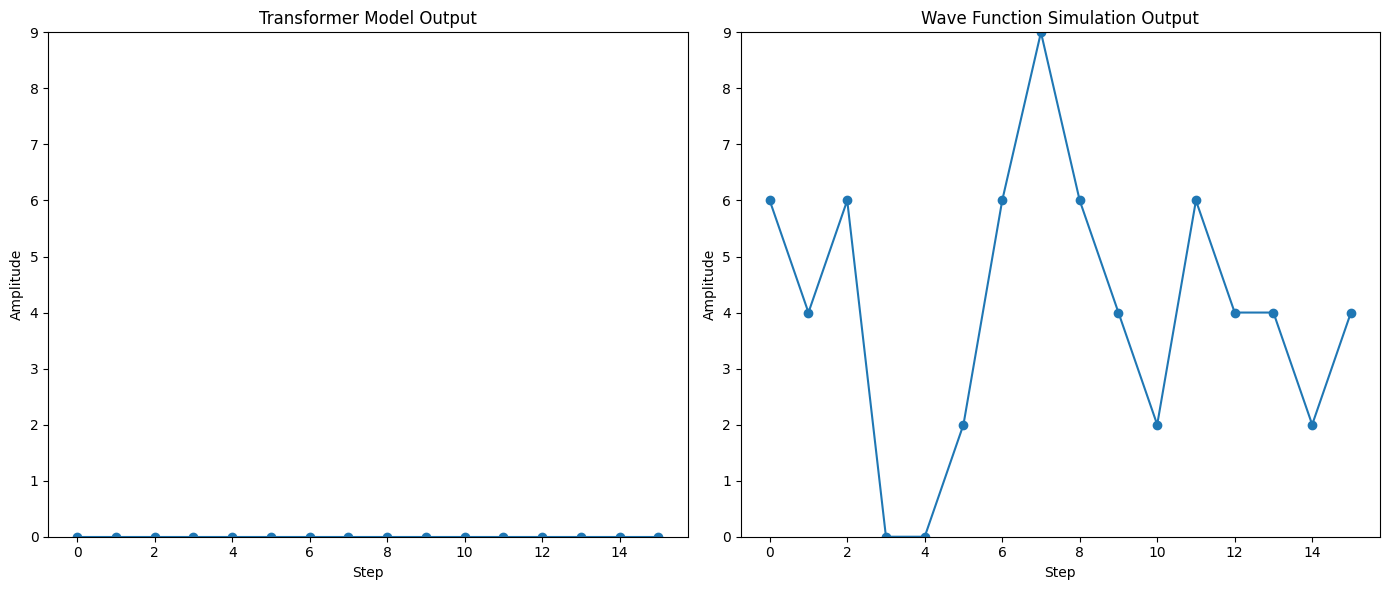

In [18]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

# Load the model (assuming this part is correct)
models = [SmallLLM(vocab_size, **arch) for arch in best_individual]
model = LLMEnsemble(models).to(device)
model.load_state_dict(torch.load('models/best_evolutionary_ensemble.pth'))
model.eval()

# Generate input
input_length = 16
input_wave = generate_random_wave_profile(input_length)
print(f"Input wave: {input_wave}")

# Encode input with start and end tokens
encoded_input = enc('s' + ''.join(map(str, input_wave)) + 'e')
input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)

# Generate output
with torch.no_grad():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=-1)
    predicted_tokens = torch.argmax(probs, dim=-1)

    # Add these lines after generating the logits
    print("Logits shape:", logits.shape)
    print("Logits mean:", logits.mean().item())
    print("Logits std:", logits.std().item())

    # Print probabilities for the first few positions
    for i in range(5):
        print(f"Top 5 probable tokens at position {i}:")
        top_probs, top_indices = torch.topk(probs[0, i], 5)
        for prob, idx in zip(top_probs, top_indices):
            print(f"  Token: {itos[idx.item()]}, Probability: {prob.item():.4f}")

    # Check if all predicted tokens are the same
    if len(set(predicted_tokens[0].tolist())) == 1:
        print("Warning: All predicted tokens are the same!")
        
# Decode the entire output, including start and end tokens
decoded_output = ''.join([itos[i] for i in predicted_tokens[0].tolist()])
print("Raw decoded output:", decoded_output)

# Extract the actual wave values (remove 's' and 'e', and convert to integers)
generated_output = [int(char) for char in decoded_output[1:-1] if char.isdigit()]
print("Generated output:", generated_output)

# Simulate wave using the original input
sim_wave_output = wave_fn.simulate_wave_equation(input_wave)
print("Wavefn output:", sim_wave_output)

# Plotting
plt.figure(figsize=(14, 6))

# Plot for the Transformer Model Output
plt.subplot(1, 2, 1)
plt.plot(generated_output, marker='o', linestyle='-')
plt.title('Transformer Model Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(0, 9)

# Plot for the Wave Function Simulation Output
plt.subplot(1, 2, 2)
plt.plot(sim_wave_output, marker='o', linestyle='-')
plt.title('Wave Function Simulation Output')
plt.xlabel('Step')
plt.ylabel('Amplitude')
plt.ylim(0, 9)

plt.tight_layout()
plt.show()